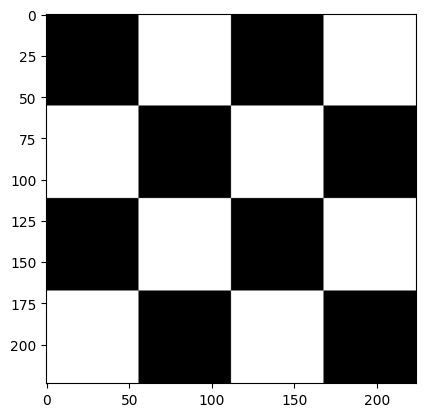

In [ ]:
import numpy as np

def generate_tile(light=(255, 255, 255), dark=(0, 0, 0)):
  row = [0] * 56 + [1] * 56
  row *= 2
  tile = [row for _ in range(56)]
  anti_row = [1 - b for b in row]
  anti_tile = [anti_row for _ in range(56)]
  tile.extend(anti_tile)
  tile *= 2
  tile = np.array(tile, dtype=np.uint8)
  light = np.array(light, dtype=np.uint8)
  dark = np.array(dark, dtype=np.uint8)
  tile = np.expand_dims(tile, 0)
  light = np.expand_dims(light, (1, 2))
  dark = np.expand_dims(dark, (1, 2))
  return (1 - tile) * dark + tile * light

import matplotlib.pyplot as plt
import torch

tile = generate_tile()
torch_tile = torch.Tensor(tile).to(torch.uint8)
plt.imshow(torch_tile.permute(1, 2, 0))

In [ ]:
from torchvision.transforms import v2

import math
from typing import Any, Callable, cast, Dict, List, Optional, Tuple, Type, Union

import PIL.Image
import torch

from torch.utils._pytree import tree_flatten, tree_unflatten, TreeSpec
from torchvision import transforms as _transforms, tv_tensors
from torchvision.transforms import _functional_tensor as _FT
from torchvision.transforms.v2 import AutoAugmentPolicy, functional as F, InterpolationMode, Transform
from torchvision.transforms.v2.functional._geometry import _check_interpolation
from torchvision.transforms.v2.functional._meta import get_size
from torchvision.transforms.v2.functional._utils import _FillType, _FillTypeJIT

from torchvision.transforms.v2._utils import _get_fill, _setup_fill_arg, check_type, is_pure_tensor

ImageOrVideo = Union[torch.Tensor, PIL.Image.Image, tv_tensors.Image, tv_tensors.Video]


def _solarize_add(
    image: ImageOrVideo, addition: int = 0, threshold: int = 128
) -> ImageOrVideo:
    bound = _FT._max_value(image.dtype) if isinstance(image, torch.Tensor) else 255
    added_image = image.to(torch.int64) + addition
    added_image = added_image.clip(0, bound).to(torch.uint8)
    return torch.where(image < threshold, added_image, image)


def _cutout(
    image: ImageOrVideo,
    pad_size: int,
    replace: int = 0,
) -> ImageOrVideo:
    _, img_h, img_w = F.get_dimensions(image)

    # Sample the center location in the image where the zero mask will be applied.
    cutout_center_height = int(torch.randint(img_h, ()))
    cutout_center_width = int(torch.randint(img_w, ()))

    lower_pad = max(0, cutout_center_height - pad_size)
    upper_pad = max(0, img_h - cutout_center_height - pad_size)
    left_pad = max(0, cutout_center_width - pad_size)
    right_pad = max(0, img_w - cutout_center_width - pad_size)

    cutout_shape = [img_h - (lower_pad + upper_pad), img_w - (left_pad + right_pad)]
    return F.erase(image, lower_pad, left_pad, cutout_shape[0], cutout_shape[1], torch.tensor(replace).unsqueeze(1).unsqueeze(1))


class RandAugment17(v2.RandAugment):
    def _apply_image_or_video_transform(
        self,
        image: ImageOrVideo,
        transform_id: str,
        magnitude: float,
        interpolation: Union[InterpolationMode, int],
        fill: Dict[Union[Type, str], _FillTypeJIT],
    ) -> ImageOrVideo:
        # Note: this cast is wrong and is only here to make mypy happy (it disagrees with torchscript)
        image = cast(torch.Tensor, image)
        fill_ = _get_fill(fill, type(image))

        if transform_id == "Identity":
            return image
        elif transform_id == "ShearX":
            # magnitude should be arctan(magnitude)
            # official autoaug: (1, level, 0, 0, 1, 0)
            # https://github.com/tensorflow/models/blob/dd02069717128186b88afa8d857ce57d17957f03/research/autoaugment/augmentation_transforms.py#L290
            # compared to
            # torchvision:      (1, tan(level), 0, 0, 1, 0)
            # https://github.com/pytorch/vision/blob/0c2373d0bba3499e95776e7936e207d8a1676e65/torchvision/transforms/functional.py#L976
            return F.affine(
                image,
                angle=0.0,
                translate=[0, 0],
                scale=1.0,
                shear=[math.degrees(math.atan(magnitude)), 0.0],
                interpolation=interpolation,
                fill=fill_,
                center=[0, 0],
            )
        elif transform_id == "ShearY":
            # magnitude should be arctan(magnitude)
            # See above
            return F.affine(
                image,
                angle=0.0,
                translate=[0, 0],
                scale=1.0,
                shear=[0.0, math.degrees(math.atan(magnitude))],
                interpolation=interpolation,
                fill=fill_,
                center=[0, 0],
            )
        elif transform_id == "TranslateX":
            return F.affine(
                image,
                angle=0.0,
                translate=[int(magnitude), 0],
                scale=1.0,
                interpolation=interpolation,
                shear=[0.0, 0.0],
                fill=fill_,
            )
        elif transform_id == "TranslateY":
            return F.affine(
                image,
                angle=0.0,
                translate=[0, int(magnitude)],
                scale=1.0,
                interpolation=interpolation,
                shear=[0.0, 0.0],
                fill=fill_,
            )
        elif transform_id == "Rotate":
            return F.rotate(image, angle=magnitude, interpolation=interpolation, fill=fill_)
        elif transform_id == "Brightness":
            return F.adjust_brightness(image, brightness_factor=1.0 + magnitude)
        elif transform_id == "Color":
            return F.adjust_saturation(image, saturation_factor=1.0 + magnitude)
        elif transform_id == "Contrast":
            return F.adjust_contrast(image, contrast_factor=1.0 + magnitude)
        elif transform_id == "Sharpness":
            return F.adjust_sharpness(image, sharpness_factor=1.0 + magnitude)
        elif transform_id == "Posterize":
            return F.posterize(image, bits=int(magnitude))
        elif transform_id == "Solarize":
            bound = _FT._max_value(image.dtype) if isinstance(image, torch.Tensor) else 255.0
            return F.solarize(image, threshold=bound * magnitude)
        elif transform_id == "AutoContrast":
            return F.autocontrast(image)
        elif transform_id == "Equalize":
            return F.equalize(image)
        elif transform_id == "Invert":
            return F.invert(image)
        elif transform_id == "SolarizeAdd":
            return _solarize_add(image, addition=int(magnitude))
        elif transform_id == "Cutout":
            return _cutout(image, pad_size=int(magnitude), replace=fill_)
        else:
            raise ValueError(f"No transform available for {transform_id}")


cutout_const = 40
translate_const = 100
MAX_LEVEL = 10

translate_magnitude = lambda num_bins, _h, _w: torch.linspace(0.0, translate_const, num_bins)
shear_magnitude = lambda num_bins, _h, _w: torch.linspace(0.0, 0.3, num_bins)
enhance_magnitude = lambda num_bins, _h, _w: torch.linspace(0, 0.9, num_bins)  # It was -0.9, 0.9 but negative magnitude results in the opposite effect

RandAugment17._AUGMENTATION_SPACE = {
    "TranslateX": (translate_magnitude, True),
    "TranslateY": (translate_magnitude, True),
    "ShearX": (shear_magnitude, True),
    "ShearY": (shear_magnitude, True),
    "Rotate": (lambda num_bins, height, width: torch.linspace(0.0, 30.0, num_bins), True),
    "Brightness": (enhance_magnitude, False),
    "Color": (enhance_magnitude, False),
    "Contrast": (enhance_magnitude, False),
    "Sharpness": (enhance_magnitude, False),
    "Posterize": (  # Unchanged!
        lambda num_bins, height, width: (8 - (torch.arange(num_bins) / ((num_bins - 1) / 4))).round().int(),
        False,
    ),
    "Solarize": (lambda num_bins, height, width: torch.linspace(1.0, 0.0, num_bins), False),  # Unchanged!
    "AutoContrast": (lambda num_bins, height, width: None, False),  # Unchanged!
    "Equalize": (lambda num_bins, height, width: None, False),  # Unchanged!
    "Invert": (lambda num_bins, height, width: None, False),  # "New" (equivalent to MAX_LEVEL Solarize)!
    "SolarizeAdd": (lambda num_bins, height, width: torch.linspace(0., 110., num_bins), False),  # New!
    "Cutout": (lambda num_bins, height, width: torch.linspace(0., float(cutout_const), num_bins), False),  # New!
    # https://github.com/pytorch/vision/pull/6609
}
transform = RandAugment17(2, 10, num_magnitude_bins=MAX_LEVEL + 1, fill=[128] * 3)

In [ ]:
# v2.RandAugment._AUGMENTATION_SPACE = {
#         "TranslateX": (
#             lambda num_bins, height, width: torch.linspace(0.0, 150.0 / 331.0 * width, num_bins),
#             True,
#         ),
#         "TranslateY": (
#             lambda num_bins, height, width: torch.linspace(0.0, 150.0 / 331.0 * height, num_bins),
#             True,
#         ),
#     }
# transform = v2.RandAugment(1, 10, fill=[128] * 3)

In [ ]:
# torch.linspace(0.0, 150.0 / 331.0 * 224, 31)[10]  # 224 * 150 / 331 * 10 / 30 = 33.8368580060423

In [ ]:
row = 2
col = 4

# out = torch.cat([torch.cat([transform(torch_tile) for _ in range(col)], dim=2) for _ in range(row)], dim=1)
# plt.imshow(out.permute(1, 2, 0))

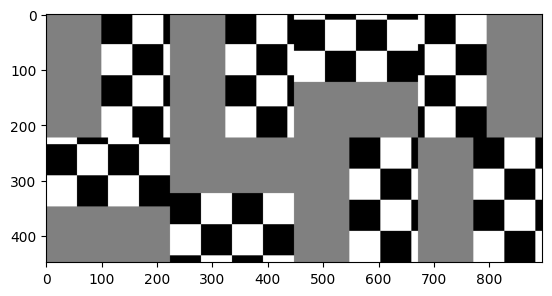

In [ ]:
RandAugment17._AUGMENTATION_SPACE = {
        "TranslateX": (translate_magnitude, True),
        "TranslateY": (translate_magnitude, True),
    }
transform = RandAugment17(1, 10, num_magnitude_bins=MAX_LEVEL + 1, fill=[128] * 3)

out = torch.cat([torch.cat([transform(torch_tile) for _ in range(col)], dim=2) for _ in range(row)], dim=1)
plt.imshow(out.permute(1, 2, 0))

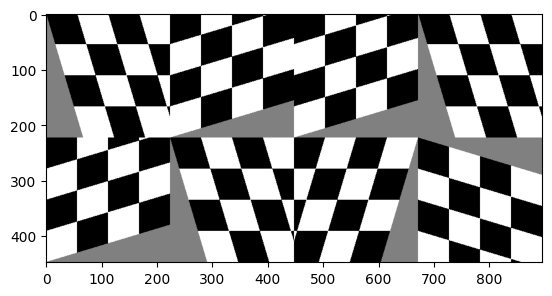

In [ ]:
v2.RandAugment._AUGMENTATION_SPACE = {
        "ShearX": (shear_magnitude, True),
        "ShearY": (shear_magnitude, True),
    }
transform = v2.RandAugment(1, 10, num_magnitude_bins=MAX_LEVEL + 1, fill=[128] * 3)

out = torch.cat([torch.cat([transform(torch_tile) for _ in range(col)], dim=2) for _ in range(row)], dim=1)
plt.imshow(out.permute(1, 2, 0))

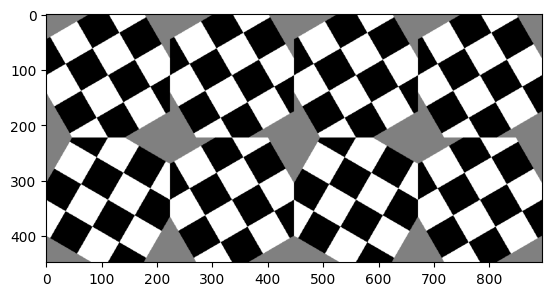

In [ ]:
v2.RandAugment._AUGMENTATION_SPACE = {
        "Rotate": (lambda num_bins, height, width: torch.linspace(0.0, 30.0, num_bins), True),
    }
transform = v2.RandAugment(1, 10, num_magnitude_bins=MAX_LEVEL + 1, fill=[128] * 3)

out = torch.cat([torch.cat([transform(torch_tile) for _ in range(col)], dim=2) for _ in range(row)], dim=1)
plt.imshow(out.permute(1, 2, 0))

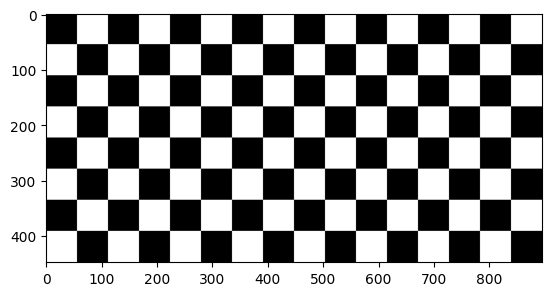

In [ ]:
v2.RandAugment._AUGMENTATION_SPACE = {
    "Brightness": (enhance_magnitude, False)
}
transform = v2.RandAugment(1, 10, num_magnitude_bins=MAX_LEVEL + 1, fill=[128] * 3)

out = torch.cat([torch.cat([transform(torch_tile) for _ in range(col)], dim=2) for _ in range(row)], dim=1)
plt.imshow(out.permute(1, 2, 0))

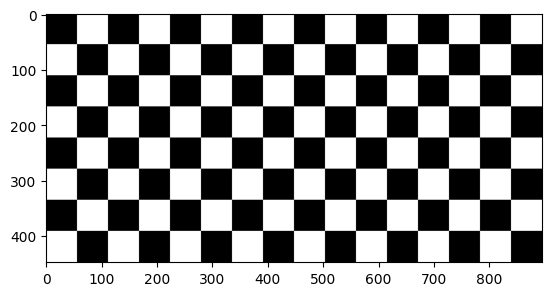

In [ ]:
v2.RandAugment._AUGMENTATION_SPACE = {
    "Brightness": (enhance_magnitude, False)
}
transform = v2.RandAugment(1, 0, num_magnitude_bins=MAX_LEVEL + 1, fill=[128] * 3)

out = torch.cat([torch.cat([transform(torch_tile) for _ in range(col)], dim=2) for _ in range(row)], dim=1)
plt.imshow(out.permute(1, 2, 0))

In [ ]:
import collections
collections.Counter(tuple(pixel) for row in out.permute(1, 2, 0).numpy() for pixel in row)

Counter({(0, 0, 0): 200704, (255, 255, 255): 200704})

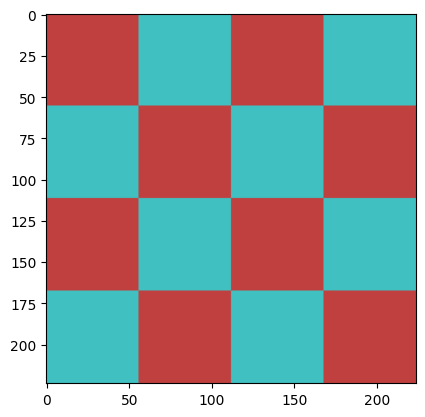

In [ ]:
color_tile = generate_tile(light=(64, 192, 192), dark=(192, 64, 64))
torch_color_tile = torch.Tensor(color_tile).to(torch.uint8)
plt.imshow(torch_color_tile.permute(1, 2, 0))

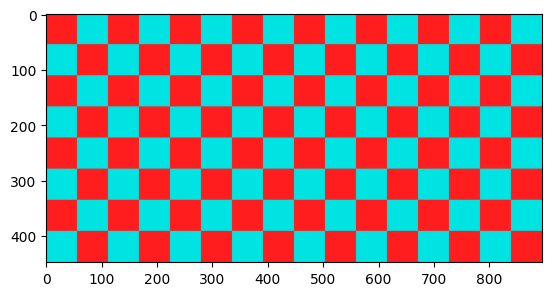

In [ ]:
v2.RandAugment._AUGMENTATION_SPACE = {
    "Color": (enhance_magnitude, False)
}
transform = v2.RandAugment(1, 10, num_magnitude_bins=MAX_LEVEL + 1, fill=[128] * 3)

out = torch.cat([torch.cat([transform(torch_color_tile) for _ in range(col)], dim=2) for _ in range(row)], dim=1)
plt.imshow(out.permute(1, 2, 0))

In [ ]:
collections.Counter(tuple(pixel) for row in out.permute(1, 2, 0).numpy() for pixel in row)

Counter({(255, 29, 29): 200704, (0, 227, 227): 200704})

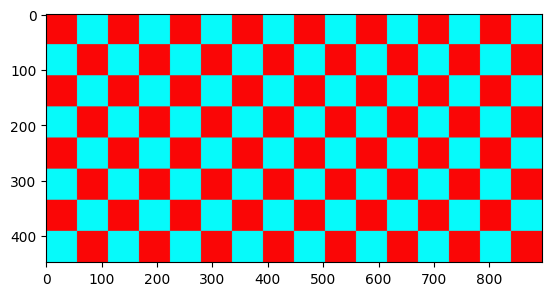

In [ ]:
v2.RandAugment._AUGMENTATION_SPACE = {
    "Contrast": (enhance_magnitude, False),
}
transform = v2.RandAugment(1, 10, num_magnitude_bins=MAX_LEVEL + 1, fill=[128] * 3)

out = torch.cat([torch.cat([transform(torch_color_tile) for _ in range(col)], dim=2) for _ in range(row)], dim=1)
plt.imshow(out.permute(1, 2, 0))

In [ ]:
collections.Counter(tuple(pixel) for row in out.permute(1, 2, 0).numpy() for pixel in row)

Counter({(250, 6, 6): 200704, (6, 250, 250): 200704})

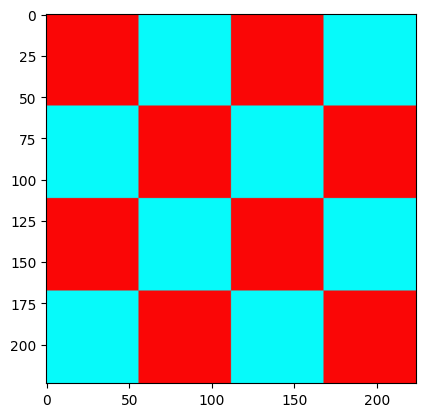

In [ ]:
from torchvision.transforms.v2 import functional as F
out = F.adjust_contrast(torch_color_tile, contrast_factor=1.9)
plt.imshow(out.permute(1, 2, 0))

In [ ]:
collections.Counter(tuple(pixel) for row in out.permute(1, 2, 0).numpy() for pixel in row)

Counter({(250, 6, 6): 25088, (6, 250, 250): 25088})

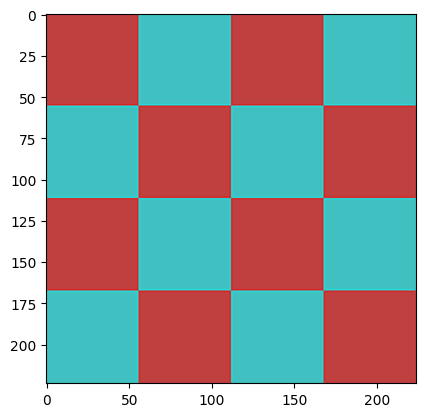

In [ ]:
v2.RandAugment._AUGMENTATION_SPACE = {
    "Sharpness": (enhance_magnitude, False),
}
transform = v2.RandAugment(1, 10, num_magnitude_bins=MAX_LEVEL + 1, fill=[128] * 3)

out = transform(torch_color_tile)
plt.imshow(out.permute(1, 2, 0))

In [ ]:
collections.Counter(tuple(pixel) for row in out.permute(1, 2, 0).numpy() for pixel in row)

Counter({(192, 64, 64): 23774,
         (64, 192, 192): 23774,
         (219, 37, 37): 1296,
         (37, 219, 219): 1296,
         (227, 28, 28): 18,
         (28, 227, 227): 18})

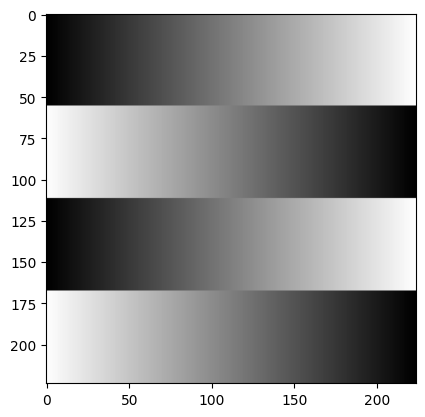

In [ ]:
def generate_gradient(light=(255, 255, 255), dark=(0, 0, 0)):
  row = np.linspace(0.0, 1.0, 224)
  tile = [row for _ in range(56)]
  anti_row = [1 - b for b in row]
  anti_tile = [anti_row for _ in range(56)]
  tile.extend(anti_tile)
  tile *= 2
  tile = np.array(tile)
  light = np.array(light, dtype=np.uint8)
  dark = np.array(dark, dtype=np.uint8)
  tile = np.expand_dims(tile, 0)
  light = np.expand_dims(light, (1, 2))
  dark = np.expand_dims(dark, (1, 2))
  return (1 - tile) * dark + tile * light

gradient = generate_gradient()
torch_gradient = torch.Tensor(gradient).to(torch.uint8)
plt.imshow(torch_gradient.permute(1, 2, 0))

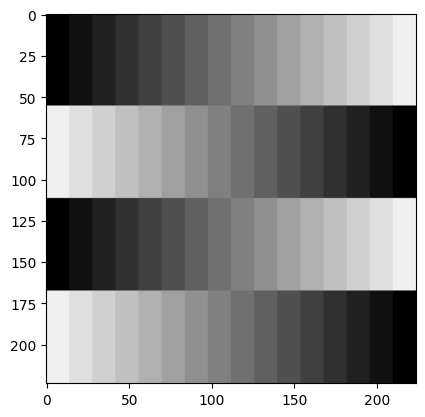

In [ ]:
v2.RandAugment._AUGMENTATION_SPACE = {
    "Posterize": (  # Unchanged!
        lambda num_bins, height, width: (8 - (torch.arange(num_bins) / ((num_bins - 1) / 4))).round().int(),
        False,
    ),
}
transform = v2.RandAugment(1, 10, num_magnitude_bins=MAX_LEVEL + 1, fill=[128] * 3)

out = transform(torch_gradient)
plt.imshow(out.permute(1, 2, 0))

In [ ]:
collections.Counter(tuple(pixel) for row in out.permute(1, 2, 0).numpy() for pixel in row)

Counter({(0, 0, 0): 3136,
         (16, 16, 16): 3136,
         (32, 32, 32): 3136,
         (48, 48, 48): 3136,
         (64, 64, 64): 3136,
         (80, 80, 80): 3136,
         (96, 96, 96): 3136,
         (112, 112, 112): 3136,
         (128, 128, 128): 3136,
         (144, 144, 144): 3136,
         (160, 160, 160): 3136,
         (176, 176, 176): 3136,
         (192, 192, 192): 3136,
         (208, 208, 208): 3136,
         (224, 224, 224): 3136,
         (240, 240, 240): 3136})

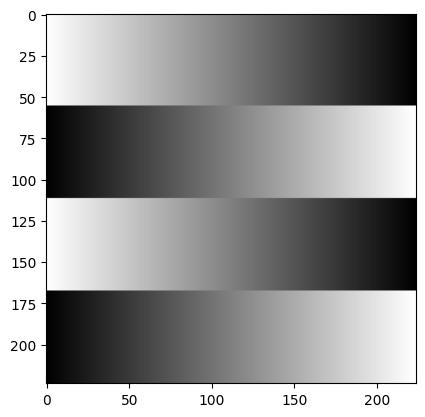

In [ ]:
v2.RandAugment._AUGMENTATION_SPACE = {
    "Solarize": (lambda num_bins, height, width: torch.linspace(1.0, 0.0, num_bins), False),
}
transform = v2.RandAugment(1, 10, num_magnitude_bins=MAX_LEVEL + 1, fill=[128] * 3)

out = transform(torch_gradient)
plt.imshow(out.permute(1, 2, 0))

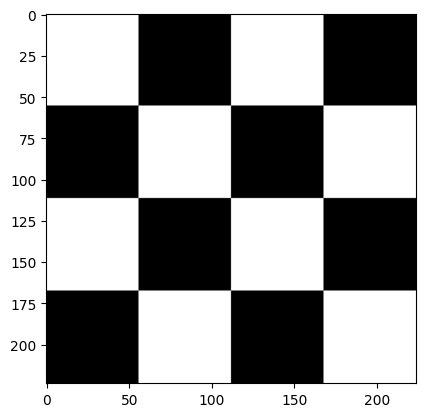

In [ ]:
out = transform(torch_tile)
plt.imshow(out.permute(1, 2, 0))

In [ ]:
collections.Counter(tuple(pixel) for row in out.permute(1, 2, 0).numpy() for pixel in row)

Counter({(255, 255, 255): 25088, (0, 0, 0): 25088})

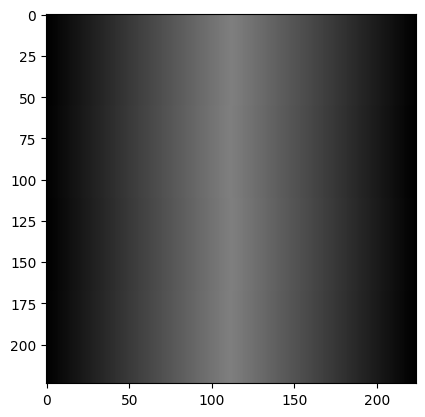

In [ ]:
v2.RandAugment._AUGMENTATION_SPACE = {
    "Solarize": (lambda num_bins, height, width: torch.linspace(1.0, 0.0, num_bins), False),
}
transform = v2.RandAugment(1, MAX_LEVEL // 2, num_magnitude_bins=MAX_LEVEL + 1, fill=[128] * 3)

out = transform(torch_gradient)
plt.imshow(out.permute(1, 2, 0))

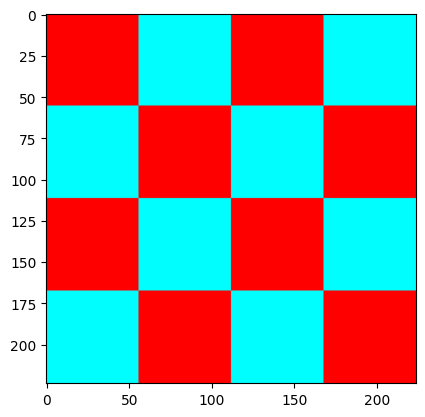

In [ ]:
v2.RandAugment._AUGMENTATION_SPACE = {
    "AutoContrast": (lambda num_bins, height, width: None, False),
}
transform = v2.RandAugment(1, MAX_LEVEL, num_magnitude_bins=MAX_LEVEL + 1, fill=[128] * 3)

out = transform(torch_color_tile)
plt.imshow(out.permute(1, 2, 0))

In [ ]:
collections.Counter(tuple(pixel) for row in out.permute(1, 2, 0).numpy() for pixel in row)

Counter({(254, 0, 0): 25088, (0, 254, 254): 25088})

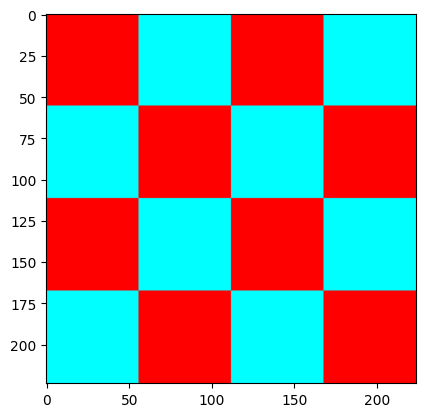

In [ ]:
v2.RandAugment._AUGMENTATION_SPACE = {
    "Equalize": (lambda num_bins, height, width: None, False),
}
transform = v2.RandAugment(1, MAX_LEVEL, num_magnitude_bins=MAX_LEVEL + 1, fill=[128] * 3)

out = transform(torch_color_tile)
plt.imshow(out.permute(1, 2, 0))

In [ ]:
collections.Counter(tuple(pixel) for row in out.permute(1, 2, 0).numpy() for pixel in row)

Counter({(255, 0, 0): 25088, (0, 255, 255): 25088})

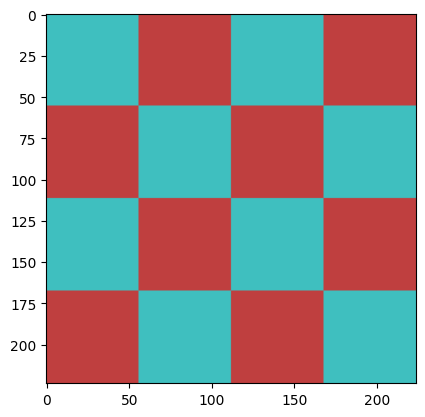

In [ ]:
v2.RandAugment._AUGMENTATION_SPACE = {
    "Invert": (lambda num_bins, height, width: None, False),  # "New"!
}
transform = v2.RandAugment(1, MAX_LEVEL, num_magnitude_bins=MAX_LEVEL + 1, fill=[128] * 3)

out = transform(torch_color_tile)
plt.imshow(out.permute(1, 2, 0))

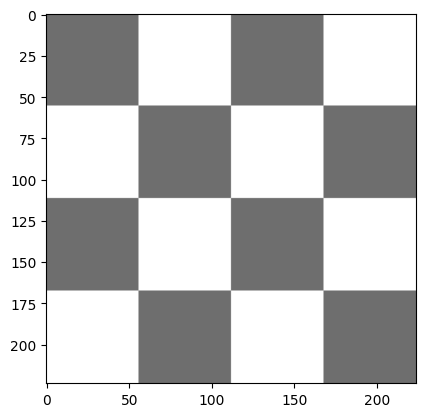

In [ ]:
RandAugment17._AUGMENTATION_SPACE = {
    "SolarizeAdd": (lambda num_bins, height, width: torch.linspace(0., 110., num_bins), False),  # New!
}
transform = RandAugment17(1, 10, num_magnitude_bins=MAX_LEVEL + 1, fill=[128] * 3)

out = transform(torch_tile)
plt.imshow(out.permute(1, 2, 0))

In [ ]:
collections.Counter(tuple(pixel) for row in out.permute(1, 2, 0).numpy() for pixel in row)

Counter({(110, 110, 110): 25088, (255, 255, 255): 25088})

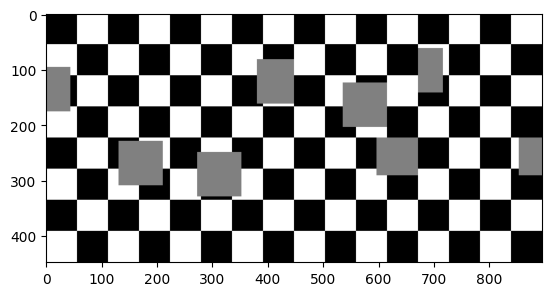

In [ ]:
RandAugment17._AUGMENTATION_SPACE = {
    "Cutout": (lambda num_bins, height, width: torch.linspace(0., float(cutout_const), num_bins), False),  # New!
}
transform = RandAugment17(1, 10, num_magnitude_bins=MAX_LEVEL + 1, fill=[128] * 3)

out = torch.cat([torch.cat([transform(torch_tile) for _ in range(col)], dim=2) for _ in range(row)], dim=1)
plt.imshow(out.permute(1, 2, 0))

In [ ]:
collections.Counter(tuple(pixel) for row in out.permute(1, 2, 0).numpy() for pixel in row)

Counter({(0, 0, 0): 182464, (255, 255, 255): 179308, (128, 128, 128): 39636})

In [ ]:
import tensorflow as tf

In [ ]:
!git clone https://github.com/google-research/big_vision

Cloning into 'big_vision'...
remote: Enumerating objects: 1266, done.
remote: Counting objects: 100% (777/777), done.
remote: Compressing objects: 100% (351/351), done.
remote: Total 1266 (delta 516), reused 515 (delta 400), pack-reused 489
Receiving objects: 100% (1266/1266), 4.39 MiB | 23.41 MiB/s, done.
Resolving deltas: 100% (693/693), done.


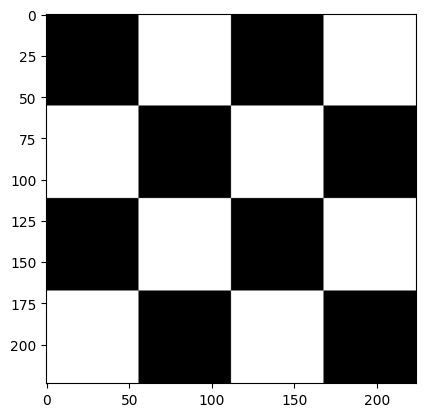

In [ ]:
tf_tile = tf.constant(tile, dtype=tf.uint8)
tf_tile = tf.transpose(tf_tile, perm=(1, 2, 0))
plt.imshow(tf_tile)

In [ ]:
import importlib
!pip3 install tensorflow_addons
m = importlib.import_module(f"big_vision.big_vision.pp.autoaugment")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
def distort_image_with_randaugment(image, num_layers, magnitude, available_ops):
  """Applies the RandAugment policy to `image`.
  RandAugment is from the paper https://arxiv.org/abs/1909.13719,
  Args:
    image: `Tensor` of shape [height, width, 3] representing an image.
    num_layers: Integer, the number of augmentation transformations to apply
      sequentially to an image. Represented as (N) in the paper. Usually best
      values will be in the range [1, 3].
    magnitude: Integer, shared magnitude across all augmentation operations.
      Represented as (M) in the paper. Usually best values are in the range
      [5, 30].
  Returns:
    The augmented version of `image`.
  """
  replace_value = [128] * 3
  augmentation_hparams = m.HParams(
      cutout_const=40, translate_const=100)

  for layer_num in range(num_layers):
    op_to_select = tf.random.uniform(
        [], maxval=len(available_ops), dtype=tf.int32)
    random_magnitude = float(magnitude)
    with tf.name_scope('randaug_layer_{}'.format(layer_num)):
      for (i, op_name) in enumerate(available_ops):
        prob = tf.random.uniform([], minval=0.2, maxval=0.8, dtype=tf.float32)
        func, _, args = m._parse_policy_info(op_name, prob, random_magnitude,
                                           replace_value, augmentation_hparams)
        image = tf.cond(
            tf.equal(i, op_to_select),
            lambda selected_func=func, selected_args=args: selected_func(
                image, *selected_args),
            # pylint:enable=g-long-lambda
            lambda: image)
  return image

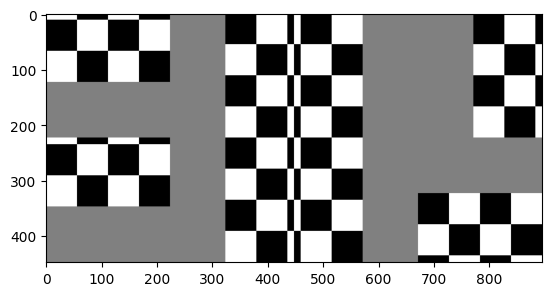

In [ ]:
out = tf.concat([tf.concat([distort_image_with_randaugment(tf_tile, 1, 10, ['TranslateX', 'TranslateY']) for _ in range(col)], axis=1) for _ in range(row)], axis=0)
plt.imshow(out)

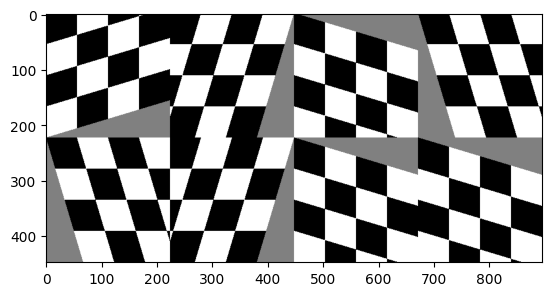

In [ ]:
out = tf.concat([tf.concat([distort_image_with_randaugment(tf_tile, 1, 10, ['ShearX', 'ShearY']) for _ in range(col)], axis=1) for _ in range(row)], axis=0)
plt.imshow(out)

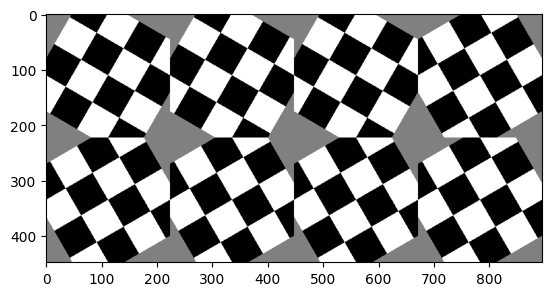

In [ ]:
out = tf.concat([tf.concat([distort_image_with_randaugment(tf_tile, 1, 10, ['Rotate']) for _ in range(col)], axis=1) for _ in range(row)], axis=0)
plt.imshow(out)

Instructions for updating:
Use `tf.cast` instead.


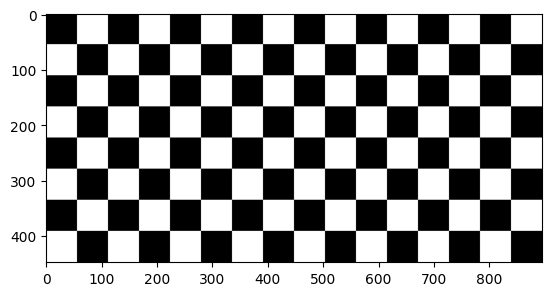

In [ ]:
out = tf.concat([tf.concat([distort_image_with_randaugment(tf_tile, 1, 10, ['Brightness']) for _ in range(col)], axis=1) for _ in range(row)], axis=0)
plt.imshow(out)

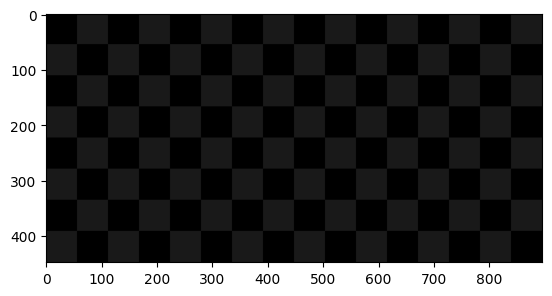

In [ ]:
out = tf.concat([tf.concat([distort_image_with_randaugment(tf_tile, 1, 0, ['Brightness']) for _ in range(col)], axis=1) for _ in range(row)], axis=0)
plt.imshow(out)

In [ ]:
collections.Counter(tuple(pixel) for row in out.numpy() for pixel in row)

Counter({(0, 0, 0): 200704, (25, 25, 25): 200704})

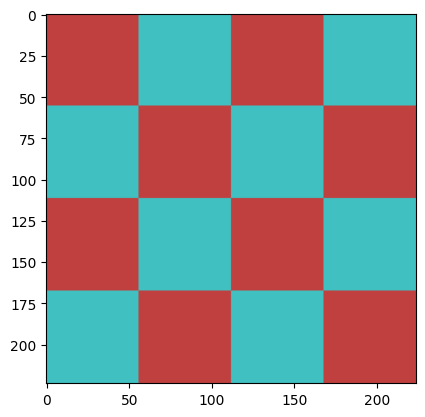

In [ ]:
tf_color_tile = tf.constant(color_tile, dtype=tf.uint8)
tf_color_tile = tf.transpose(tf_color_tile, perm=(1, 2, 0))
plt.imshow(tf_color_tile)

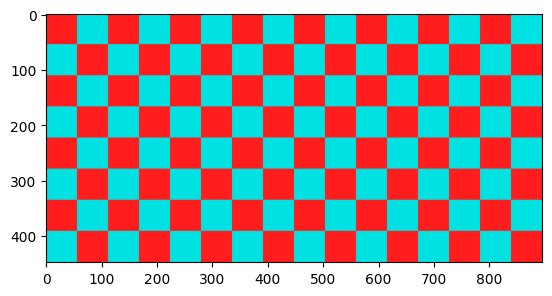

In [ ]:
out = tf.concat([tf.concat([distort_image_with_randaugment(tf_color_tile, 1, 10, ['Color']) for _ in range(col)], axis=1) for _ in range(row)], axis=0)
plt.imshow(out)

In [ ]:
collections.Counter(tuple(pixel) for row in out.numpy() for pixel in row)

Counter({(255, 29, 29): 200704, (0, 226, 226): 200704})

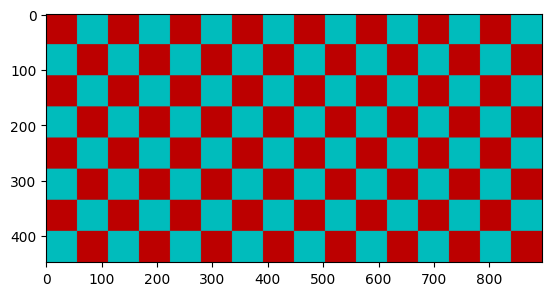

In [ ]:
out = tf.concat([tf.concat([distort_image_with_randaugment(tf_color_tile, 1, 10, ['Contrast']) for _ in range(col)], axis=1) for _ in range(row)], axis=0)
plt.imshow(out)

In [ ]:
collections.Counter(tuple(pixel) for row in out.numpy() for pixel in row)

Counter({(188, 0, 0): 200704, (0, 188, 188): 200704})

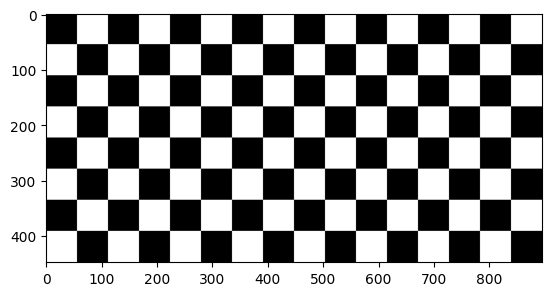

In [ ]:
out = tf.concat([tf.concat([distort_image_with_randaugment(tf_tile, 1, 10, ['Contrast']) for _ in range(col)], axis=1) for _ in range(row)], axis=0)
plt.imshow(out)

In [ ]:
collections.Counter(tuple(pixel) for row in out.numpy() for pixel in row)

Counter({(0, 0, 0): 200704, (255, 255, 255): 200704})

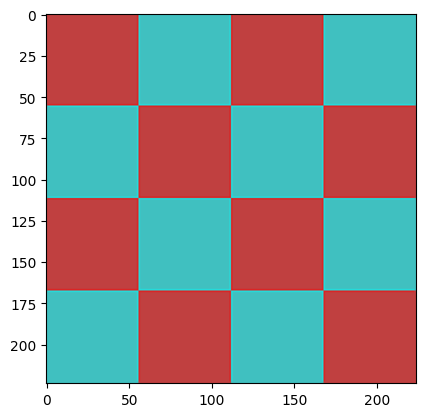

In [ ]:
out = distort_image_with_randaugment(tf_color_tile, 1, 10, ['Sharpness'])
plt.imshow(out)

In [ ]:
"""
# torchvision result:
Counter({(192, 64, 64): 23774,
         (64, 192, 192): 23774,
         (219, 37, 37): 1296,
         (37, 219, 219): 1296,
         (227, 28, 28): 18,
         (28, 227, 227): 18})"""

collections.Counter(tuple(pixel) for row in out.numpy() for pixel in row)

Counter({(192, 64, 64): 23774,
         (64, 192, 192): 23774,
         (219, 37, 37): 1296,
         (37, 219, 219): 1296,
         (228, 28, 28): 18,
         (28, 228, 228): 18})

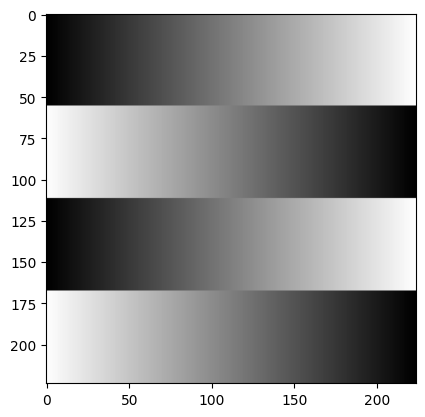

In [ ]:
tf_gradient = tf.constant(gradient, dtype=tf.uint8)
tf_gradient = tf.transpose(tf_gradient, perm=(1, 2, 0))
plt.imshow(tf_gradient)

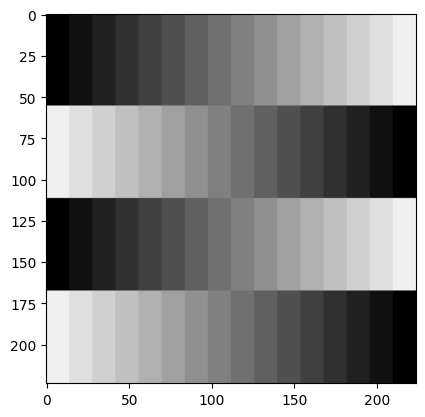

In [ ]:
out = distort_image_with_randaugment(tf_gradient, 1, 10, ["Posterize"])
plt.imshow(out)

In [ ]:
collections.Counter(tuple(pixel) for row in out.numpy() for pixel in row)

Counter({(0, 0, 0): 3136,
         (16, 16, 16): 3136,
         (32, 32, 32): 3136,
         (48, 48, 48): 3136,
         (64, 64, 64): 3136,
         (80, 80, 80): 3136,
         (96, 96, 96): 3136,
         (112, 112, 112): 3136,
         (128, 128, 128): 3136,
         (144, 144, 144): 3136,
         (160, 160, 160): 3136,
         (176, 176, 176): 3136,
         (192, 192, 192): 3136,
         (208, 208, 208): 3136,
         (224, 224, 224): 3136,
         (240, 240, 240): 3136})

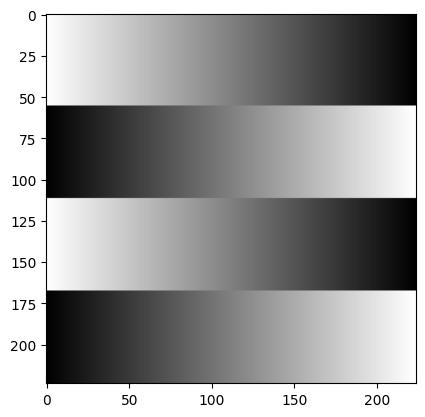

In [ ]:
out = distort_image_with_randaugment(tf_gradient, 1, 10, ["Solarize"])
plt.imshow(out)

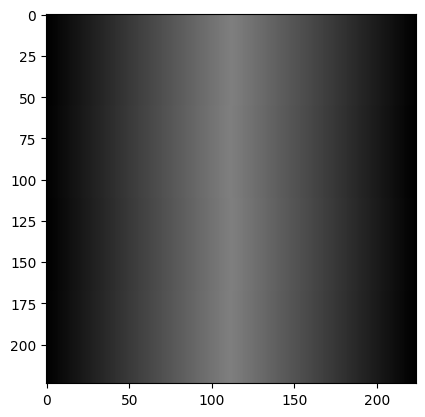

In [ ]:
out = distort_image_with_randaugment(tf_gradient, 1, 5, ["Solarize"])
plt.imshow(out)

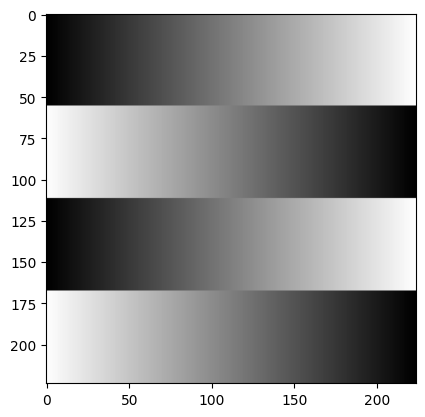

In [ ]:
plt.imshow(tf_gradient)

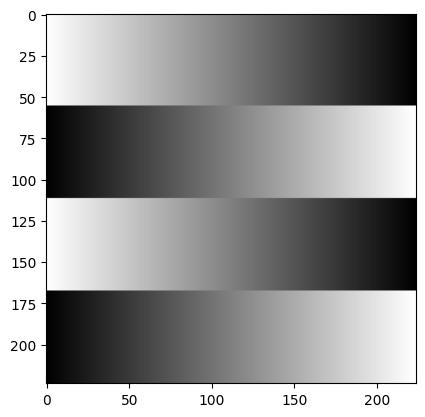

In [ ]:
out = m.solarize(tf_gradient, 256)
plt.imshow(out)

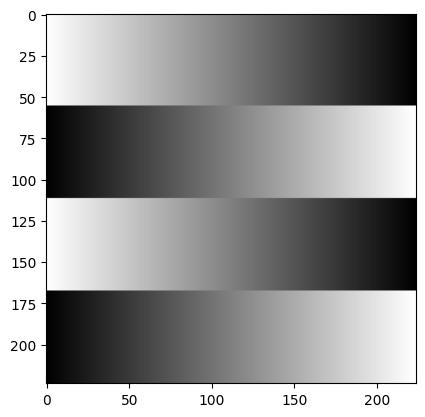

In [ ]:
out = m.solarize(tf_gradient, 0)
plt.imshow(out)

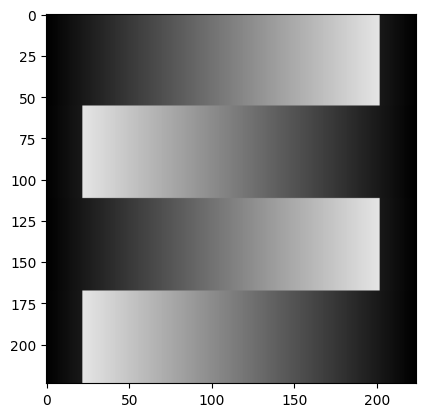

In [ ]:
out = m.solarize(tf_gradient, 230)
plt.imshow(out)

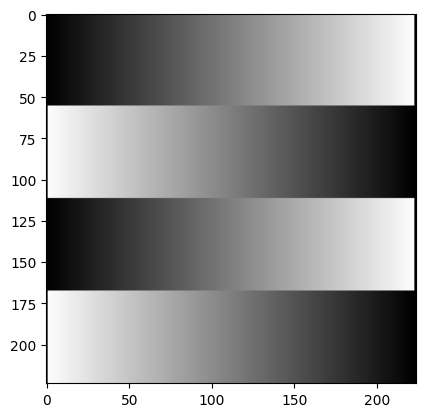

In [ ]:
out = m.solarize(tf_gradient, 255)
plt.imshow(out)

In [ ]:
tf_gradient < 256

<tf.Tensor: shape=(224, 224, 3), dtype=bool, numpy=
array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, Fa

In [ ]:
tf_gradient < 128

<tf.Tensor: shape=(224, 224, 3), dtype=bool, numpy=
array([[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [ True,  True,  T

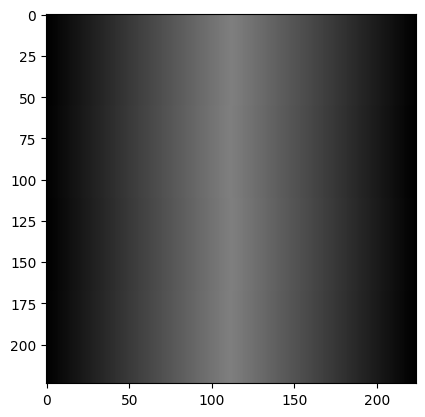

In [ ]:
out = m.solarize(tf_gradient, 128)
plt.imshow(out)

In [ ]:
torch_gradient >= 0

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]]

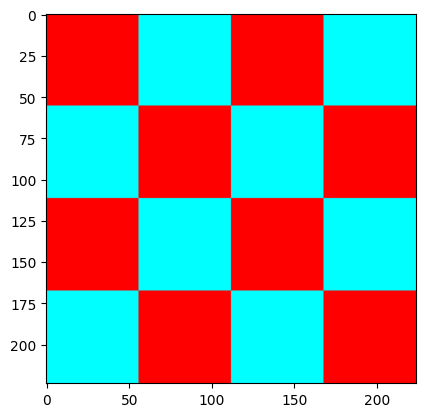

In [ ]:
out = distort_image_with_randaugment(tf_color_tile, 1, 10, ['AutoContrast'])
plt.imshow(out)

In [ ]:
collections.Counter(tuple(pixel) for row in out.numpy() for pixel in row)

Counter({(255, 0, 0): 25088, (0, 255, 255): 25088})

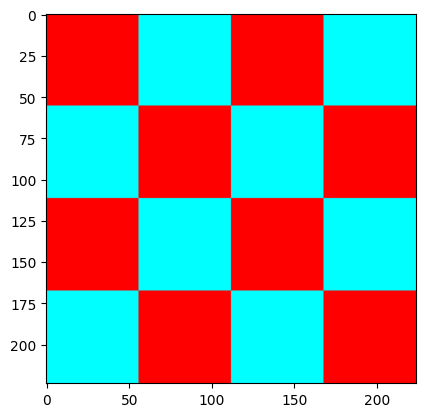

In [ ]:
out = distort_image_with_randaugment(tf_color_tile, 1, 10, ['Equalize'])
plt.imshow(out)

In [ ]:
collections.Counter(tuple(pixel) for row in out.numpy() for pixel in row)

Counter({(255, 0, 0): 25088, (0, 255, 255): 25088})

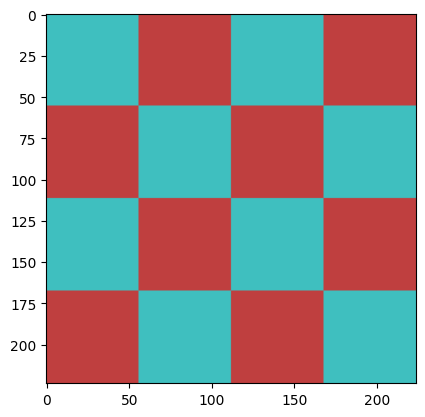

In [ ]:
out = distort_image_with_randaugment(tf_color_tile, 1, 10, ['Invert'])
plt.imshow(out)

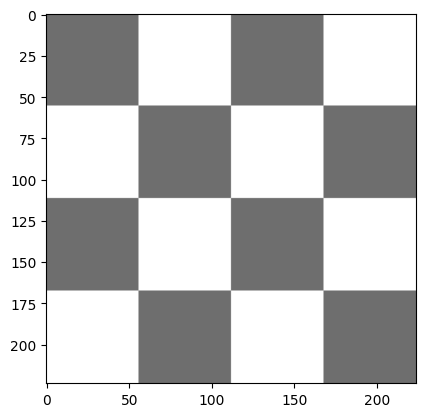

In [ ]:
out = distort_image_with_randaugment(tf_tile, 1, 10, ['SolarizeAdd'])
plt.imshow(out)

In [ ]:
collections.Counter(tuple(pixel) for row in out.numpy() for pixel in row)

Counter({(110, 110, 110): 25088, (255, 255, 255): 25088})

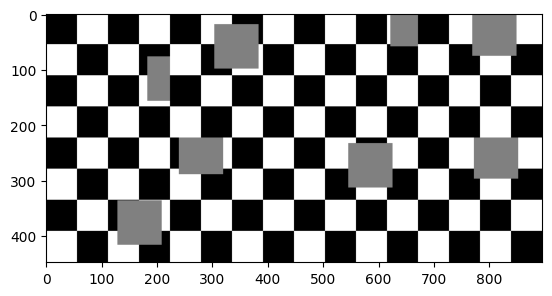

In [ ]:
out = tf.concat([tf.concat([distort_image_with_randaugment(tf_tile, 1, 10, ['Cutout']) for _ in range(col)], axis=1) for _ in range(row)], axis=0)
plt.imshow(out)

In [ ]:
collections.Counter(tuple(pixel) for row in out.numpy() for pixel in row)

Counter({(0, 0, 0): 179564, (255, 255, 255): 179004, (128, 128, 128): 42840})

tf.Tensor(
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0 25088     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0 25088     0
     0     0     0     0     0     0    

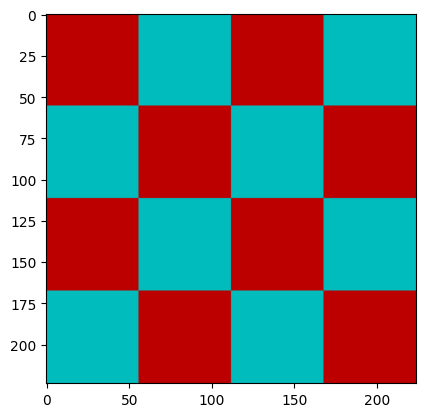

In [ ]:
def blend(image1, image2, factor):
  """Blend image1 and image2 using 'factor'.
  Factor can be above 0.0.  A value of 0.0 means only image1 is used.
  A value of 1.0 means only image2 is used.  A value between 0.0 and
  1.0 means we linearly interpolate the pixel values between the two
  images.  A value greater than 1.0 "extrapolates" the difference
  between the two pixel values, and we clip the results to values
  between 0 and 255.
  Args:
    image1: An image Tensor of type uint8.
    image2: An image Tensor of type uint8.
    factor: A floating point value above 0.0.
  Returns:
    A blended image Tensor of type uint8.
  """
  if factor == 0.0:
    return tf.convert_to_tensor(image1)
  if factor == 1.0:
    return tf.convert_to_tensor(image2)

  image1 = tf.cast(image1, dtype=tf.double)
  image2 = tf.cast(image2, dtype=tf.double)

  difference = image2 - image1
  scaled = factor * difference

  # Do addition in float.
  temp = tf.cast(image1, dtype=tf.double) + scaled

  # Interpolate
  if factor > 0.0 and factor < 1.0:
    # Interpolation means we always stay within 0 and 255.
    return tf.cast(temp, tf.uint8)

  # Extrapolate:
  #
  # We need to clip and then cast.
  return tf.cast(tf.clip_by_value(temp, 0.0, 255.0), tf.uint8)

def contrast(image, factor):
  """Equivalent of PIL Contrast."""
  degenerate = tf.image.rgb_to_grayscale(image)
  # Cast before calling tf.histogram.
  degenerate = tf.cast(degenerate, tf.int32)

  # Compute the grayscale histogram, then compute the mean pixel value,
  # and create a constant image size of that value.  Use that as the
  # blending degenerate target of the original image.
  hist = tf.histogram_fixed_width(degenerate, [0, 255], nbins=256)
  print(hist)
  mean = tf.reduce_sum(tf.cast(hist, tf.float32)) / 256.0
  print(mean)
  degenerate = tf.ones_like(degenerate, dtype=tf.float32) * mean
  degenerate = tf.clip_by_value(degenerate, 0.0, 255.0)
  degenerate = tf.image.grayscale_to_rgb(tf.cast(degenerate, tf.uint8))
  return blend(degenerate, image, factor)

plt.imshow(contrast(tf_color_tile, 1.9))

tf.Tensor(
[25088     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

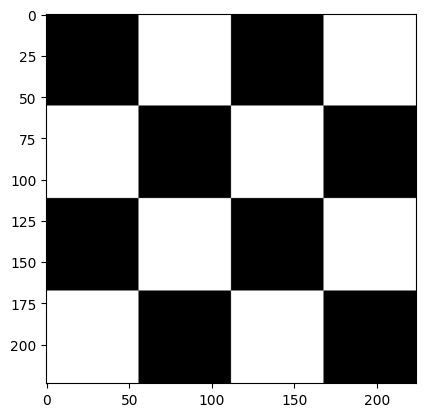

In [ ]:
plt.imshow(contrast(tf_tile, 1.9))

tf.Tensor(
[50176     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

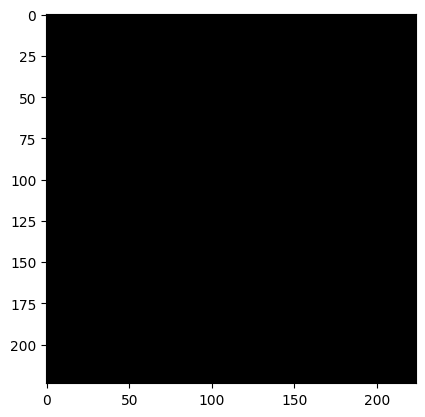

In [ ]:
plt.imshow(contrast(tf.zeros_like(tf_tile), 1.9))

In [ ]:
def contrast(image, factor):
  """Equivalent of PIL Contrast."""
  image_height = tf.shape(image)[0]
  image_width = tf.shape(image)[1]
  degenerate = tf.image.rgb_to_grayscale(image)
  # Cast before calling tf.histogram.
  degenerate = tf.cast(degenerate, tf.int32)

  # Compute the grayscale histogram, then compute the mean pixel value,
  # and create a constant image size of that value.  Use that as the
  # blending degenerate target of the original image.
  hist = tf.histogram_fixed_width(degenerate, [0, 255], nbins=256)
  print(hist)
  mean = tf.reduce_sum(tf.cast(hist, tf.float32) * tf.linspace(0., 255., 256)) / float(image_height * image_width)
  print(mean)
  degenerate = tf.ones_like(degenerate, dtype=tf.float32) * mean
  degenerate = tf.clip_by_value(degenerate, 0.0, 255.0)
  degenerate = tf.image.grayscale_to_rgb(tf.cast(degenerate, tf.uint8))
  return blend(degenerate, image, factor)

tf.Tensor(
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0 25088     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0 25088     0
     0     0     0     0     0     0    

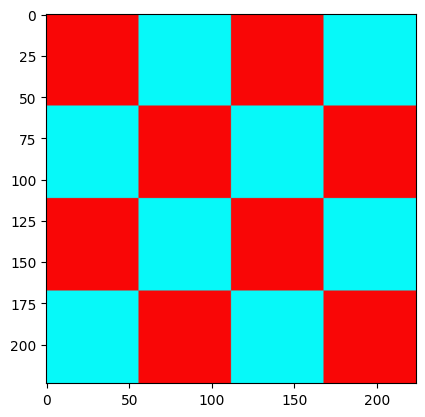

In [ ]:
plt.imshow(contrast(tf_color_tile, 1.9))

tf.Tensor(
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0 25088     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0 25088     0
     0     0     0     0     0     0    

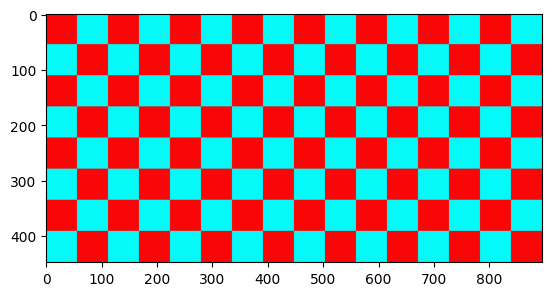

In [ ]:
out = tf.concat([tf.concat([contrast(tf_color_tile, 1.9) for _ in range(col)], axis=1) for _ in range(row)], axis=0)
plt.imshow(out)

In [ ]:
collections.Counter(tuple(pixel) for row in out.numpy() for pixel in row)

Counter({(249, 6, 6): 200704, (6, 249, 249): 200704})

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 5228467711_122f9b7af1_b.jpg to 5228467711_122f9b7af1_b.jpg


In [ ]:
uploaded.keys()

dict_keys(['5228467711_122f9b7af1_b.jpg'])

In [ ]:
image = tf.io.decode_image(
    uploaded['5228467711_122f9b7af1_b.jpg'], channels=3, expand_animations=False)  # big_vision "preprocess_ops.decode" default

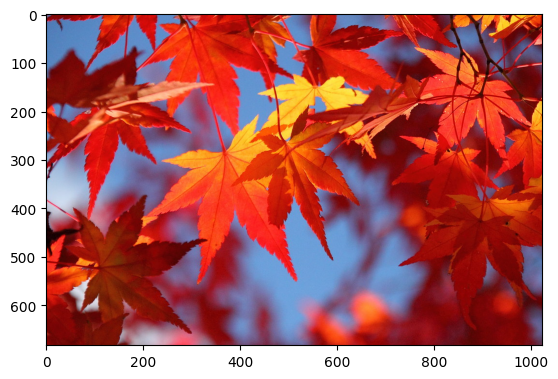

In [ ]:
plt.imshow(image)

In [ ]:
def resize_small(image, smaller_size):
  h, w = tf.shape(image)[0], tf.shape(image)[1]
  factor = (
      tf.cast(smaller_size, tf.float32) /
      tf.cast(tf.minimum(h, w), tf.float32))

  h = tf.cast(tf.round(tf.cast(h, tf.float32) * factor), tf.int32)
  w = tf.cast(tf.round(tf.cast(w, tf.float32) * factor), tf.int32)

  dtype = image.dtype
  tf_dtype = tf.type_spec_from_value(image).dtype
  image = tf.image.resize(image, (h, w), method='area')  # "it always anti-aliases"
  return tf.cast(tf.clip_by_value(image, tf_dtype.min, tf_dtype.max), dtype)

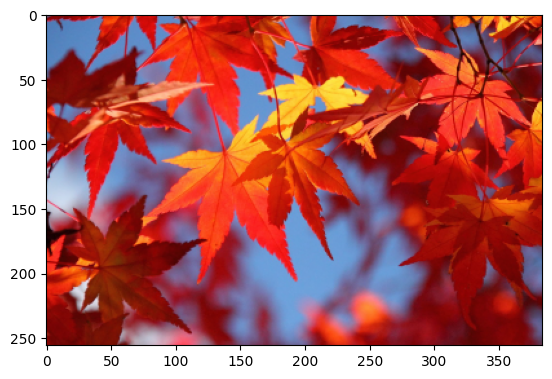

In [ ]:
resized = resize_small(image, 256)
plt.imshow(resized)

In [ ]:
precise_image = tf.image.decode_jpeg(uploaded['5228467711_122f9b7af1_b.jpg'], channels=3, dct_method="INTEGER_ACCURATE")  # big_vision "preprocess_ops.decode" with channels=3, precise=True

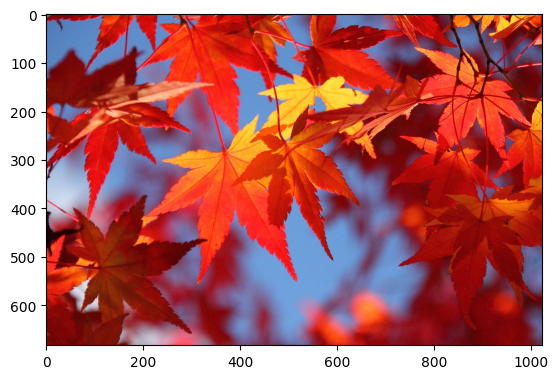

In [ ]:
plt.imshow(precise_image)

In [ ]:
image[:3, :3, :]

<tf.Tensor: shape=(3, 3, 3), dtype=uint8, numpy=
array([[[176,  35,  54],
        [152,   7,  36],
        [161,   8,  54]],

       [[158,  22,  34],
        [148,  15,  36],
        [163,  32,  72]],

       [[160,  11,  30],
        [163,  29,  54],
        [169,  63, 103]]], dtype=uint8)>

In [ ]:
precise_image[:3, :3, :]

<tf.Tensor: shape=(3, 3, 3), dtype=uint8, numpy=
array([[[177,  34,  54],
        [154,   7,  36],
        [163,   7,  54]],

       [[159,  21,  36],
        [150,  14,  38],
        [164,  31,  74]],

       [[162,  10,  31],
        [165,  28,  56],
        [171,  62, 103]]], dtype=uint8)>

In [ ]:
import torchvision
torch_image = torchvision.io.decode_image(torch.frombuffer(uploaded['5228467711_122f9b7af1_b.jpg'], dtype=torch.uint8))

<ipython-input-93-5a2976ecb027>:2: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:1524.)
  torch_image = torchvision.io.decode_image(torch.frombuffer(uploaded['5228467711_122f9b7af1_b.jpg'], dtype=torch.uint8))


In [ ]:
torch_image.permute(1, 2, 0)[:3, :3, :]

tensor([[[177,  34,  54],
         [154,   7,  36],
         [163,   7,  54]],

        [[159,  21,  36],
         [150,  14,  38],
         [164,  31,  74]],

        [[162,  10,  31],
         [165,  28,  56],
         [171,  62, 103]]], dtype=torch.uint8)

In [ ]:
from PIL import Image
to_image = v2.ToImage()
with Image.open('5228467711_122f9b7af1_b.jpg') as im:
  im = to_image(im).permute(1, 2, 0)
  print(im[:3, :3, :])

tensor([[[177,  34,  54],
         [154,   7,  36],
         [163,   7,  54]],

        [[159,  21,  36],
         [150,  14,  38],
         [164,  31,  74]],

        [[162,  10,  31],
         [165,  28,  56],
         [171,  62, 103]]], dtype=torch.uint8)


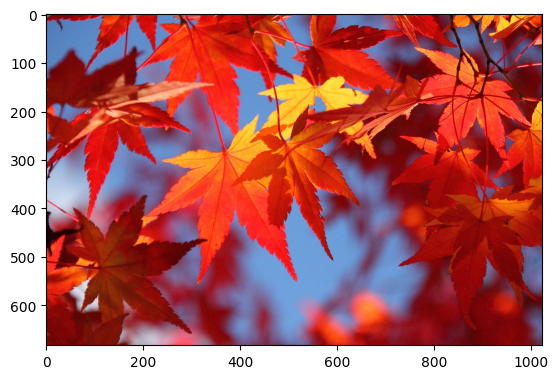

In [ ]:
plt.imshow(torch_image.permute(1, 2, 0))

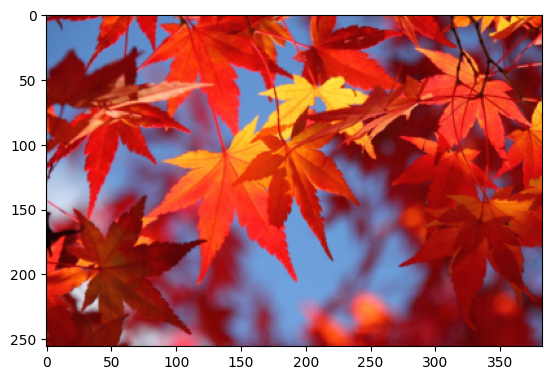

In [ ]:
resize = v2.Resize(256)
torch_resized = resize(torch_image)
plt.imshow(torch_resized.permute(1, 2, 0))

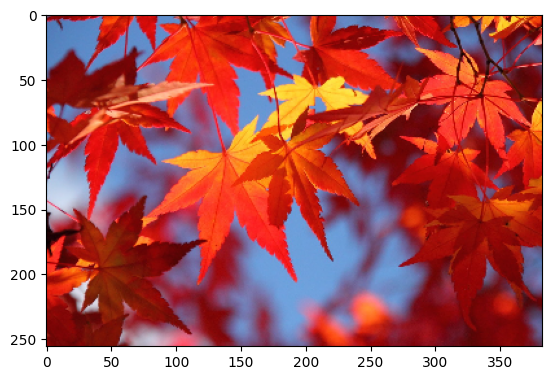

In [ ]:
resize = v2.Resize(256, antialias=False)
torch_resized = resize(torch_image)
plt.imshow(torch_resized.permute(1, 2, 0))